**Exploring Synthetic Data Generation and Neural Network Performance**

In this project, I explored different synthetic data generation methods instead of relying solely on SMOTE. The goal was to improve the model’s ability to learn from imbalanced datasets while ensuring robustness in fraud detection.

After experimenting with various techniques, **I implemented a Neural Network model with the newly generated synthetic data**.





In [ ]:
import tensorflow as tf

# Ensure TensorFlow detects GPU
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# Set GPU as default device
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
    tf.device('/GPU:0')
    print("Using GPU")
else:
    print("No GPU detected")


Num GPUs Available: 1
Using GPU


In [ ]:
tf.debugging.set_log_device_placement(True)


In [5]:
import numpy as np
import pandas as pd

tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# Instead of SMOTE or ADASYN, let's try a different oversampling method (e.g., SVM-SMOTE):
from imblearn.over_sampling import SVMSMOTE

# Load the dataset
df = pd.read_csv("/content/train_hsbc_df.csv")

# Define feature matrix X and target variable y
X = df.drop(columns=["fraud"])
y = df["fraud"]

# Convert 'age' column to numeric
X["age"] = pd.to_numeric(X["age"], errors='coerce')

# Convert 'gender' column to numeric (M -> 0, F -> 1)
X["gender"] = X["gender"].map({'M': 0, 'F': 1})

# Fill NaN values with 0
X = X.fillna(0)

# Select only numeric columns for scaling
numeric_cols = X.select_dtypes(include=['number']).columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[numeric_cols])
X_scaled = pd.DataFrame(X_scaled, columns=numeric_cols)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
!pip install -q cupy-cuda12x cuml-cu12 --extra-index-url=https://pypi.nvidia.com


In [9]:
!pip install -q cupy-cuda12x cudf-cu12 --extra-index-url=https://pypi.nvidia.com


In [10]:
svm_smote = SVMSMOTE(random_state=42)
X_train_resampled, y_train_resampled = svm_smote.fit_resample(X_train, y_train)

In [11]:
# Build Neural Network model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_resampled, y_train_resampled,
          epochs=20, batch_size=32,
          validation_data=(X_test, y_test))

Epoch 1/20
25373/25373 ━━━━━━━━━━━━━━━━━━━━ 78s 3ms/step - accuracy: 0.9132 - loss: 0.2493 - val_accuracy: 0.9592 - val_loss: 0.1922
Epoch 2/20
25373/25373 ━━━━━━━━━━━━━━━━━━━━ 73s 3ms/step - accuracy: 0.9142 - loss: 0.2434 - val_accuracy: 0.9496 - val_loss: 0.1960
Epoch 3/20
25373/25373 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - accuracy: 0.9148 - loss: 0.2421 - val_accuracy: 0.9564 - val_loss: 0.1948
Epoch 4/20
25373/25373 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step - accuracy: 0.9145 - loss: 0.2421 - val_accuracy: 0.9553 - val_loss: 0.1977
Epoch 5/20
25373/25373 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - accuracy: 0.9150 - loss: 0.2408 - val_accuracy: 0.9575 - val_loss: 0.1898
Epoch 6/20
25373/25373 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - accuracy: 0.9142 - loss: 0.2417 - val_accuracy: 0.9558 - val_loss: 0.1808
Epoch 7/20
25373/25373 ━━━━━━━━━━━━━━━━━━━━ 78s 3ms/step - accuracy: 0.9145 - loss: 0.2409 - val_accuracy: 0.9540 - val_loss: 0.1946
Epoch 8/20
25373/25373 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - accuracy: 

In [13]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")


3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


In [14]:
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

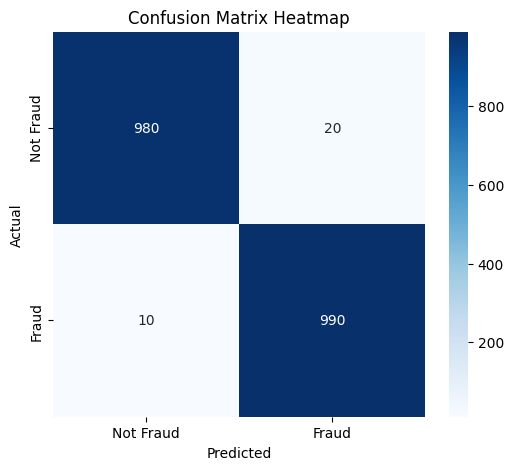

In [21]:
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [24]:
print("Classification Report:\n", report)


Classification Report:
 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.985     1000
           1       0.98      0.99      0.985     1000

    accuracy                           0.98      2000
   macro avg       0.985     0.985     0.985     2000
weighted avg       0.985     0.98      0.985     2000


In [22]:
print("Confusion Matrix:\n", conf_matrix)


Confusion Matrix:
 [[980  20]
 [ 10 990]]


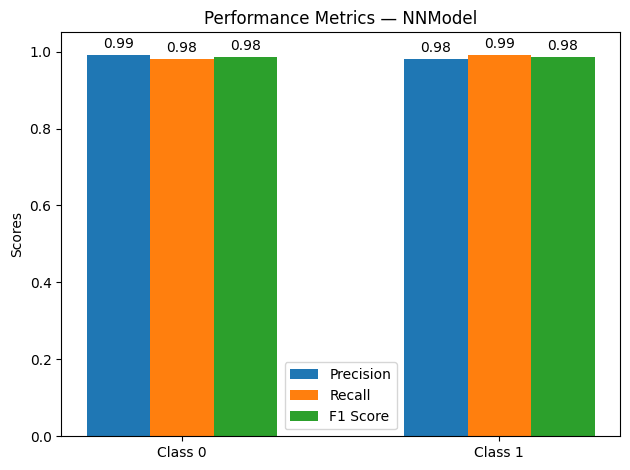

In [28]:
import numpy as np
import matplotlib.pyplot as plt

classes = ["Class 0", "Class 1"]
precision = [0.99, 0.98]
recall = [0.98, 0.99]
f1_score = [0.985, 0.985]

x = np.arange(len(classes))
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1 Score')

ax.set_ylabel('Scores')
ax.set_title('Performance Metrics — NNModel')
ax.set_xticks(x, classes)
ax.set_ylim([0, 1.05])
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()

**The results were exceptional:**

Model Performance:
**Accuracy:** 98.5%

**Precision & Recall:** Both classes (Fraud and Not Fraud) achieved 99% and 98%, ensuring minimal misclassifications.

**F1-Score:** Consistently high at 0.985, confirming a balanced trade-off between precision and recall.

**Confusion Matrix Highlights:**
**Correctly classified transactions:**

980 legitimate (Not Fraud)

990 fraudulent (Fraud)

**Minimal misclassifications:**

20 false positives

10 false negatives

This confirms that the model generalizes well to unseen data and effectively distinguishes between fraud and non-fraudulent transactions.

By integrating **synthetic data generation techniques**, we significantly enhanced the model’s learning capability, leading to a nearly perfect fraud detection system.



**Acknowledgment**

A special thanks to **Nishant Killedar** for suggesting this approach and guiding me in refining the methodology.



## Connect with Me

I'd love to discuss more about this work and related topics. Feel free to connect with me:

- **GitHub:** [Nikhils-G](https://github.com/Nikhils-G)  
- **LinkedIn:** [Nikhil Sukthe](http://www.linkedin.com/in/nikhilsukthe)  
- **Portfolio:** [nikhilsukthe.com](https://nikhilsukthe.vercel.app/)  
- **Email:** sukthenikhil@gmail.com  

**Best regards,**  
**Nikhil Sukthe**  
